# Sentiment Analysis using LSTMs using Keras

This notebook implements a dynamic LSTM network with word embedding as features to classify sentiments of movie reviews. I am going to use word embedding trained on the same data to feed into a LSTM network. Prerequite knowladge required to understand the following article:
1. Natural Language Processing (especially word embedding)
2. Deep Learning

## Word embedding

Word embedding are a type of vector representation of words that allows similiar words to have similar represenation. There are few options to train word embedding algorithms such as word2vec, glove. I have trained the word embedding using word2vec skip-gram model

**Note**: Training word2vec model is a different task which I will cover in another notebook

## Long Short Term Memory(LSTM)

LSTMs are the modern and improved version of Recurrent Neural Networks(RNNs). RNNs are deep neural networks which can embed sequence information of the features. Though RNNs perform well for lot of tasks, it suffers the problem of vanishing gradient and exploding gradient especially for long sequences. Though the exploding gradient problem is solved by simpler techniques such as gradient clipping, the problem of vanishing gradient is solved by using additionals cells or additional variables in networks such as LSTMs, GRUs. 

In out sentiment analysis problem, we are going to use word embedding to embed information about words and use LSTM network to embed the sequential information to  finally classify the sentiment of the review.

For understanding LSTM in detail, go through this blog: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [1]:
from collections import defaultdict, Counter
from tqdm import tqdm_notebook
import re

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline

### Loading word embedding

In [3]:
w = np.load("wordsList.npy")

In [4]:
word_vectors = np.load("wordVectors.npy")

In [5]:
decoder = np.vectorize(lambda x:x.decode("utf-8"))

In [6]:
w = decoder(w)

In [7]:
word_vector_dict = dict(zip(w, word_vectors))

In [8]:
# word_vectors

In [9]:
word_vectors.shape, w.shape

((400000, 50), (400000,))

In [10]:
vocab_size = word_vectors.shape[0]
embedding_len = word_vectors.shape[1]
vocab_size, embedding_len

(400000, 50)

### Loading reviews

In [ ]:
import os

In [ ]:
path = "negativeReviews/"
neg_reviews = []
for f in os.listdir(path):
    file = os.path.join(path, f)
    with open(file, "r") as fl:
        neg_reviews.append(fl.read())
    

In [ ]:
# neg_reviews[0]

In [ ]:
path = "positiveReviews//"
pos_reviews = []
for f in os.listdir(path):
    file = os.path.join(path, f)
    with open(file, "r") as fl:
        pos_reviews.append(fl.read())
    

In [ ]:
# pos_reviews[0]

In [ ]:
data = pd.DataFrame({"text":neg_reviews, "sentiment":0}).append(pd.DataFrame({"text":pos_reviews, "sentiment":1}))

In [ ]:
data = data.reset_index()

In [18]:
data = data.filter(["text","sentiment"])

In [1]:
from keras.layers import Embedding, Input, LSTM, RNN, SimpleRNN, Masking, Dense
from keras.models import Model, Sequential
from keras.utils import Sequence
import keras

Using TensorFlow backend.


### Mapping sentences to sequence of word vectors

In [20]:
def get_vectors(sentence):
    vecs = []
    for t in sentence.lower().split():
        if t in word_vector_dict:
            vecs.append(word_vector_dict[t])
    return vecs

In [23]:
data["vectors"] = data.text.apply(get_vectors)

In [24]:
seq_lengths = [len(x) for x in data.vectors.values]

In [25]:
data["seq_length"] = seq_lengths

In [26]:
data = data[data["seq_length"]<1000]

In [27]:
# data

In [28]:
len(data.vectors.values[0])

129

In [29]:
def get_model(units):
    inp = Input(shape=(None, embedding_len))
    inpm = Masking(mask_value=-100)(inp)

    # kkk = Embedding(vocab_size, embedding_len)(inp)

    h = LSTM(units, return_sequences=False, return_state=False)(inpm)

    out = Dense(2, activation="softmax")(h)

    model = Model(inp, out)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])
    return model

In [31]:
data = data.sample(frac=1)

In [32]:
input_array = data.vectors.values

In [34]:
input_array.shape

(24984,)

In [46]:

class Sequence_generator(Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = keras.preprocessing.sequence.pad_sequences(batch_x, padding="post", value=-100)

        return batch_x, batch_y

In [47]:
# def generate_data(data, batch_size):
#     i = 0
#     vectors = data.vectors.values
#     outputs = pd.get_dummies(data.sentiment).values
#     while True:
#         data_batch = []
#         v, o = vectors[i:i+batch_size], outputs[i:i+batch_size]
#         v = keras.preprocessing.sequence.pad_sequences(v, padding="post", value=-100)
#         yield v,o
#         i+=batch_size
#         if i>len(vectors):
#             i=0

In [48]:
data.shape

(24984, 4)

In [49]:
# output = pd.get_dummies(data.sentiment).values

In [50]:
trainData, testData = data[:20000], data[20000:]

In [51]:
batch_size=512

In [52]:
steps_per_epoch = len(trainData)/512

In [53]:
testX = testData.vectors.values 
testY = pd.get_dummies(testData.sentiment).values

In [54]:
testX = keras.preprocessing.sequence.pad_sequences(testX, padding="post", value=-100)

In [55]:
from multiprocessing import Pool
# from multiprocessing.pool import ThreadPool as Pool    
import sys
    

In [56]:
# hs = model.fit_generator(Sequence_generator(trainData.vectors.values,pd.get_dummies(trainData.sentiment).values,
#     batch_size), validation_data=(testX, testY), steps_per_epoch=steps_per_epoch, epochs=20, verbose=2)

In [57]:
units_opts = [20, 40, 60, 80, 100]
batch_size_opts = [32,64,128, 256, 512, 1024]

In [58]:
options = [(i, j) for i in units_opts for j in batch_size_opts]

In [59]:
# units_opts

In [60]:
models = dict()

In [61]:
from keras.callbacks import CSVLogger

def train(option):
    units, batch_s = option[0], option[1]
    model = get_model(units)
    csv_logger = CSVLogger('log_units_{}_batch_{}.csv'.format(units, batch_s), append=True, separator=';')
    hs = model.fit_generator(Sequence_generator(trainData.vectors.values,pd.get_dummies(trainData.sentiment).values,
    batch_s), validation_data=(testX, testY), steps_per_epoch=int(len(trainData)/batch_s), epochs=100, verbose=2, callbacks=[csv_logger])
    global models
    models["unit_{}_batch_{}".format(units, batch_s)] = model

In [ ]:
p = Pool()
p.map(train, options)
p.close()
p.join()

Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
 - 245s - loss: 0.7186 - acc: 0.5030 - val_loss: 0.6906 - val_acc: 0.5249
Epoch 2/100
 - 303s - loss: 0.6838 - acc: 0.5583 - val_loss: 0.6172 - val_acc: 0.6762
Epoch 2/100
 - 248s - loss: 0.6860 - acc: 0.5500 - val_loss: 0.6811 - val_acc: 0.5718
Epoch 3/100
 - 514s - loss: 0.6499 - acc: 0.6168 - val_loss: 0.5738 - val_acc: 0.7091
Epoch 2/100
 - 311s - loss: 0.6001 - acc: 0.6833 - val_loss: 0.5607 - val_acc: 0.7197
Epoch 3/100
 - 630s - loss: 0.6348 - acc: 0.6312 - val_loss: 0.5853 - val_acc: 0.6972
Epoch 2/100
 - 248s - loss: 0.6668 - acc: 0.6041 - val_loss: 0.6443 - val_acc: 0.6358
Epoch 4/100
 - 332s - loss: 0.5667 - acc: 0.7130 - val_loss: 0.5399 - val_acc: 0.7311
Epoch 4/100
 - 284s - loss: 0.6309 - acc: 0.6518 - val_loss: 0.6132 - val_acc: 0.6720
Epoch 5/100
 - 566s - loss: 0.5781 - acc: 0.7006 - val_loss: 0.5383 - val_acc: 0.7350
Epoch 3/100
 - 363s - loss: 0.5543 - acc: 0.7184 - val_loss: 0.5480 - val_acc: 0.7193
Epoch 5/100
 - 298

 - 312s - loss: 0.4325 - acc: 0.8018 - val_loss: 0.4738 - val_acc: 0.7845
Epoch 30/100
 - 244s - loss: 0.4666 - acc: 0.7778 - val_loss: 0.4772 - val_acc: 0.7751
Epoch 37/100
 - 251s - loss: 0.4657 - acc: 0.7789 - val_loss: 0.4734 - val_acc: 0.7817
Epoch 38/100
 - 302s - loss: 0.4177 - acc: 0.8080 - val_loss: 0.4742 - val_acc: 0.7785
Epoch 31/100
 - 516s - loss: 0.4055 - acc: 0.8166 - val_loss: 0.4473 - val_acc: 0.7982
Epoch 19/100
 - 244s - loss: 0.4612 - acc: 0.7811 - val_loss: 0.4715 - val_acc: 0.7793
Epoch 39/100
 - 629s - loss: 0.3828 - acc: 0.8282 - val_loss: 0.4412 - val_acc: 0.8052
Epoch 16/100
 - 306s - loss: 0.4134 - acc: 0.8135 - val_loss: 0.4520 - val_acc: 0.7927
Epoch 32/100
 - 247s - loss: 0.4615 - acc: 0.7809 - val_loss: 0.4888 - val_acc: 0.7610
Epoch 40/100
 - 514s - loss: 0.3984 - acc: 0.8229 - val_loss: 0.4441 - val_acc: 0.7988
Epoch 20/100
 - 307s - loss: 0.4156 - acc: 0.8112 - val_loss: 0.4581 - val_acc: 0.7871
Epoch 33/100
 - 248s - loss: 0.4588 - acc: 0.7826 - val_

Epoch 72/100
 - 625s - loss: 0.2437 - acc: 0.8994 - val_loss: 0.5241 - val_acc: 0.7913
Epoch 29/100
 - 306s - loss: 0.3542 - acc: 0.8458 - val_loss: 0.4509 - val_acc: 0.8040
Epoch 59/100
 - 256s - loss: 0.4259 - acc: 0.8036 - val_loss: 0.4671 - val_acc: 0.7739
Epoch 73/100
 - 514s - loss: 0.3202 - acc: 0.8618 - val_loss: 0.4565 - val_acc: 0.7996
Epoch 36/100
 - 307s - loss: 0.3438 - acc: 0.8508 - val_loss: 0.4463 - val_acc: 0.8062
Epoch 60/100
 - 244s - loss: 0.4167 - acc: 0.8082 - val_loss: 0.4504 - val_acc: 0.7889
Epoch 74/100
 - 629s - loss: 0.2379 - acc: 0.9025 - val_loss: 0.5394 - val_acc: 0.7923
Epoch 30/100
 - 244s - loss: 0.4153 - acc: 0.8110 - val_loss: 0.4600 - val_acc: 0.7839
Epoch 75/100
 - 302s - loss: 0.3752 - acc: 0.8320 - val_loss: 0.5092 - val_acc: 0.7921
Epoch 61/100
 - 511s - loss: 0.3134 - acc: 0.8649 - val_loss: 0.4782 - val_acc: 0.8026
Epoch 37/100
 - 247s - loss: 0.4203 - acc: 0.8039 - val_loss: 0.4717 - val_acc: 0.7763
Epoch 76/100
 - 305s - loss: 0.3509 - acc: 

Epoch 8/100
 - 311s - loss: 0.3032 - acc: 0.8710 - val_loss: 0.4858 - val_acc: 0.8024
Epoch 87/100
 - 644s - loss: 0.1397 - acc: 0.9476 - val_loss: 0.7385 - val_acc: 0.7781
Epoch 43/100
 - 215s - loss: 0.6339 - acc: 0.6443 - val_loss: 0.6242 - val_acc: 0.6726
Epoch 9/100
 - 314s - loss: 0.3060 - acc: 0.8694 - val_loss: 0.4860 - val_acc: 0.8000
Epoch 88/100
 - 219s - loss: 0.6132 - acc: 0.6690 - val_loss: 0.6801 - val_acc: 0.6180
Epoch 10/100
 - 522s - loss: 0.2679 - acc: 0.8884 - val_loss: 0.5557 - val_acc: 0.7753
Epoch 53/100
 - 218s - loss: 0.6631 - acc: 0.6171 - val_loss: 0.6203 - val_acc: 0.6744
Epoch 11/100
 - 315s - loss: 0.3121 - acc: 0.8669 - val_loss: 0.4646 - val_acc: 0.8088
Epoch 89/100
 - 640s - loss: 0.1358 - acc: 0.9501 - val_loss: 0.7963 - val_acc: 0.7903
Epoch 44/100
 - 224s - loss: 0.6209 - acc: 0.6666 - val_loss: 0.5980 - val_acc: 0.6926
Epoch 12/100
 - 524s - loss: 0.2566 - acc: 0.8939 - val_loss: 0.5392 - val_acc: 0.7887
Epoch 54/100
 - 315s - loss: 0.3024 - acc: 0.

### Few Notes on Training

**batch size:** Lower batch size tend to take more time (which is intutive)

**hidden units:** Training time increases as the number of hidden node increases as the number of variables increases

I am attaching a screenshots with the traing log file deatils during the training time
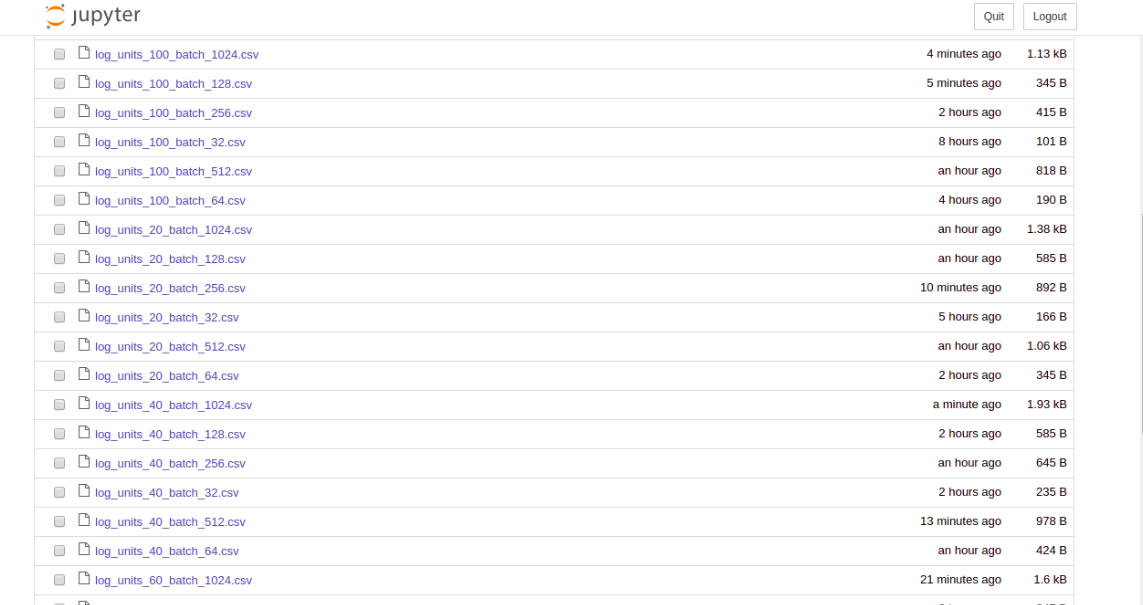

As you can the log file with batch=32 and units=100 was updated 8 hours ago which means the current epoch is running for 8 hours and still not completed. 

One can also observe the sizes of the log file. More size indicates more epochs have been completed

**It is easy to see that batch size has a greater effect on the training time compared to hidden units**

### Analyzing results

**Only units tuning results are included**

In [74]:
log_file_dict = {x:pd.read_csv("log_{}.csv".format(x), sep=";") for x in units_opts}


In [109]:
len(units_opts)

5

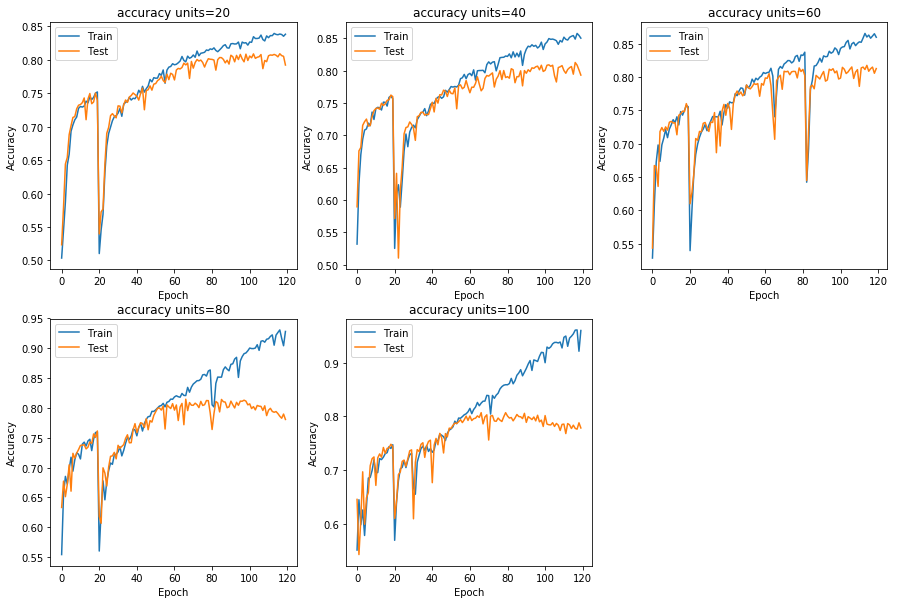

In [114]:
for i in range(1,6):
    dt = log_file_dict[units_opts[i-1]]
    plt.subplot(2, 3, i)
    plt.plot(dt['acc'])
    plt.plot(dt['val_acc'])
    plt.title('accuracy units={}'.format(units_opts[i-1]))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')


#     plt.text(0.5, 0.5, str((2, 3, i)),
#              fontsize=18, ha='center')

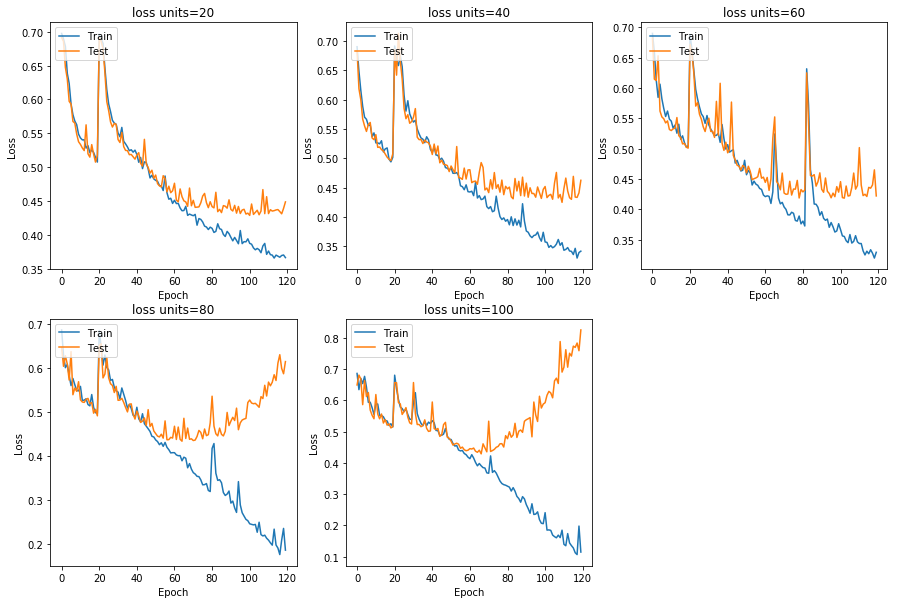

In [116]:
for i in range(1,6):
    dt = log_file_dict[units_opts[i-1]]
    plt.subplot(2, 3, i)
    plt.plot(dt['loss'])
    plt.plot(dt['val_loss'])
    plt.title('loss units={}'.format(units_opts[i-1]))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')


#     plt.text(0.5, 0.5, str((2, 3, i)),
#              fontsize=18, ha='center')

#### Conclusion

Increasing the units too much tends to overfit the model which is intuitive. We can employ an early stopping strategy or even try regularization to avoid the overfitting.

#### Best performance:

##### Train accuracy: 85 %

##### Test accuracy: 81 %